 # **CSE 6040 Project**

In this project, I'll explore the data obtained in the *MyAnimeList dataset* provided by user *Marlesson* on Kaggle (https://www.kaggle.com/marlesson/myanimelist-dataset-animes-profiles-reviews). The data contains information of pretty much every anime in existence, as well as user profiles in the aforementioned website.

The goal of the project is to create a recommendation engine, handling user preferences data with Jaccard similarity theory. To achieve this, the project uses pandas dataframes and some SciPy functions. 
The project will be divided into three parts: an initial exploration of the data, definition of functions and data cleansing, and the construction of the recommendation engine. 


## But... what is anime?
Well, according to the [Merriam-Webster Dictionary](https://www.merriam-webster.com/dictionary/anime), anime is 

> a style of animation originating in Japan that is characterized by stark colorful graphics depicting vibrant characters in action-filled plots often with fantastic or futuristic themes

While this is a oversimplification and mostly influenced by the more readily available anime genre in the West (shonen, which is geared towards kids and adolescents), it is on point regarding the origin and the nature. Let's look what [Wikipedia](https://en.wikipedia.org/wiki/Anime) has to say about anime:

> Anime is hand-drawn and computer animation originating from Japan. In Japan and in Japanese, anime (a term derived from the English word animation) describes all animated works, regardless of style or origin. However, outside of Japan and in English, anime is colloquial for Japanese animation and refers specifically to animation produced in Japan. Animation produced outside of Japan with similar style to Japanese animation is referred to as anime-influenced animation.

I can get behind this definition. In short, anime refers to Japanese animation. Anime is one of the main exports of Japan in terms of culture, and has a large following in the West. One site we can look at is [Anime News Network](https://www.animenewsnetwork.com/). It is a website that provides information about anime, including reviews, news, and information about upcoming anime. Here, users create a profile and document their preferences, engage in discussion, and explore the anime community.

## Part 1: Initial Exploration
In this part we will import the necessary packages and load the data. We will also take a peek on what's in the data. Also, we will plot some charts and see if we can uncover some insights.

In [1]:
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.spatial.distance import cosine
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In this project we will use two dataframes: animes and profiles. Let's load them and then take a peek.

In [2]:
animes = pd.read_csv('animes.csv')
profiles = pd.read_csv('profiles.csv')

In [3]:
display(animes.head())

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In the *animes* dataframe, we get data such as the names of the animes, their synopsis, the number of episodes, the rating, the genres, the popularity and the score. We will notice that the data is pretty clean, with no missing values. 

Also, we notice that the genre column is a list of strings, which is a bit confusing, but will be handled soon. Each anime can have multiple genres, since they touch different themes over the course of their runtimes.

In [4]:
display(profiles.head())

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep-05,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99


In the *profiles* dataframe, we get data such as the username, the user's age, the user's gender and their favorite animes. As we saw in the *animes* dataframe, here we have another column that is a list of strings. This column, *favorites_anime* includes the *uid* for the favorite animes of the user. 
For testing purposes, I've added my own profile at the end of the dataframe.

In [5]:
display(profiles.tail(1))

,profile,gender,birthday,favorites_anime,link
81727,eduariasv,Male,"Dec 15, 1995","['2759', '30', '3784', '32', '3785', '31']",https://myanimelist.net/profile/eduariasv


Something that has picqued my interest is the existance of both popularity and score data in the *animes* dataframe. I want to know if there's a correlation between the two, since in my experience the popular anime isn't always highly rated.

'-0.694137624731832 is the correlation between popularity and score'

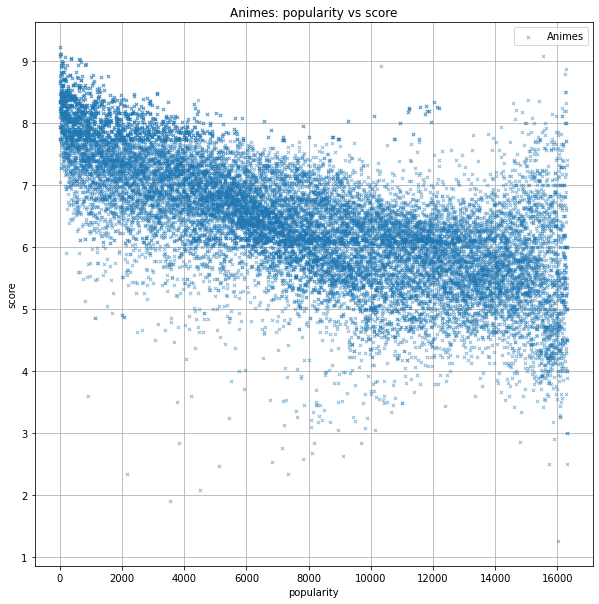

In [6]:
# Let's plot the animes dataframe, using popularity and score columns as x and y and smoothing the data with a gaussian kernel of width 0.5 and sigma = 1 
animes.plot(x='popularity', y='score', kind='scatter', s=10, alpha=0.5, label='Animes', figsize=(10,10), title='Animes: popularity vs score', legend=True, grid=True, marker='x', linewidths=1, zorder=10, rasterized=True, vmin=None, vmax=None, cmap='viridis')
# Let's get the correlation between popularity and score
popscorecorr = animes.corr()['popularity']['score']
f'{popscorecorr} is the correlation between popularity and score'

So there's a correlation indeed (-0.69). It makes sense, since the best anime might be more popular.

Now, I want to know if some genres are scored higher than others. Let's see if we can find out.

<AxesSubplot:title={'center':'score'}, xlabel='genre'>

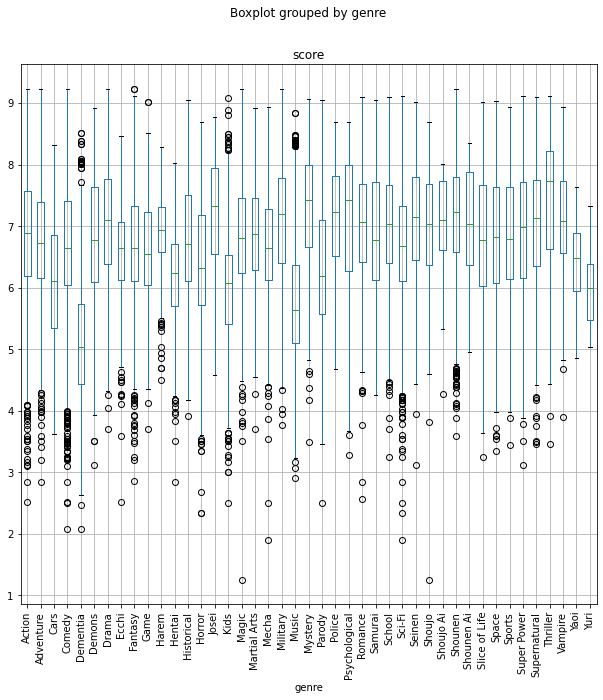

In [7]:
animes_genres = animes[['genre', 'score']].copy()
animes_genres['genre'] = animes_genres['genre'].apply(literal_eval)
animes_genres = animes_genres.explode('genre')
# Create a boxplot of the genres and scores, sorting by mean score per genre
animes_genres.boxplot(column='score', by='genre', figsize=(10,10), fontsize=10, grid=True, rot=90, zorder=10)

There's a huge variability in the scores of the genres, so one shouldn't judge an anime based on the genres alone. However, steer clear of the last two genres...

## 2. Data Cleansing and Function Building
In this part, we'll clean the dataframes to remove the unnecessary columns and rows, and then build functions to handle the data.

In [8]:
# From animes, let's keep only the columns uid, title, genre, and score
animes = animes[['uid', 'title', 'genre', 'score']]
# From profiles, let's keep only the columns favorites_anime and profile
profiles = profiles[['favorites_anime', 'profile']]

In [9]:
# We have to create profile_map, a dictionary that uses the profile as key and the index as value
profile_map = {row[1]: i for i, row in profiles.iterrows()}

In [10]:
# Let's replace ''', '[' and ']' with '', and split the string into a list in the favorites_anime column
profiles['favorites_anime'] = profiles['favorites_anime'].str.replace('[', '', regex=True).str.replace(']', '', regex=True).str.replace('\'', '', regex=True).str.split(',')
# In the profiles data, we have the uid of the favorite animes in list form. Let's explode the column to get favorites on a 1:1 basis
profiles = profiles.explode('favorites_anime')
profiles.head()
# Now, we'll have to filter the profiles dataframe to only keep the rows with values in the favorites_anime column
profiles = profiles[profiles['favorites_anime'] != '']
# We have to treat this column as int64, otherwise the sparse matrix will not work
profiles['favorites_anime'] = profiles['favorites_anime'].astype('int64')
# Let's add a column at the date with just the value of 1, to signal that the user (index) has watched the anime
profiles['has_watched'] = 1

I want to create some functions that will handle the different steps of our recommendation engine. 

Before we do this, let's create our COO matrix in order to be more efficient in the first step.

In [11]:
# Let's calculate how many different animes are in the data
n_animes = profiles['favorites_anime'].max() + 1
# Then, let's calculate how many different users are in the data
n_users = profiles.index.max() + 1
# Now, we're ready to create our COO matrix
rec_matrix = coo_matrix((profiles['has_watched'], (profiles.index, profiles['favorites_anime'])), shape=(n_users, n_animes))

Our first function will return the animes that a user has watched, given the targetuser's profile. We will also add an optional argument in order to know if we want the IDs or the names of the animes.

In [12]:
# Create a function that, given the targetuser, returns the animes that the targetuser has watched as a list
def get_watched_animes(targetuser, profiles = profiles, profile_map = profile_map, literal = False):
    # Get the index of the target user
    i = profile_map[targetuser]
    # Get the watched animes of the target user
    watched = profiles.loc[i, 'favorites_anime']
    # Return the watched animes as a list
    if literal:
        return get_animes(watched.tolist())
    else:
        return watched.tolist()

I also want to create a [Jaccard similarity function](https://en.wikipedia.org/wiki/Jaccard_index). This function will be used to calculate the similarity between two sets of animes, expressed in arrays.

In [13]:
# We have to create a jaccard similarity function, that takes two arrays and returns the score
def jaccard(a1, a2):
    cosine_sim = cosine(a1, a2)
    return cosine_sim / (a1.size + a2.size - cosine_sim)

The next function will leverage on the jaccard similarity function to calculate the similarity between two users, and return a list of animes, keeping only the top 1% of the animes.

In [14]:
# We also have to define a similarity function
def profile_similarity(mat, profile_map, targetuser):
    A = mat.tocsr()
    i = profile_map[targetuser]
    a_i = A[i, :].toarray().reshape(A.shape[1])
    y = A.dot(a_i)
    names = [name for name, _ in profile_map.items()]
    sims = [jaccard(a_i, A[coord, :].toarray().reshape(A.shape[1])) for _, coord in profile_map.items()]
    df = pd.DataFrame({'key': names, 'similarity': sims}).sort_values('similarity', ascending=False)
    # return df filtered to filter key column on values differtent than targetuser
    df =  df[df['key'] != targetuser]
    # Also, filter similarity column to keep values greater than 0
    df = df[df['similarity'] > 0]
    # Finally, keep the top 1% of the similarities
    df = df.sort_values('similarity', ascending=False).head(int(len(df) * 0.01)) 
    return df

This next function will use all we have learned so far to recommend animes to a user. It will take the user's profile and the animes dataframe as inputs, and return a list of animes, substracting the ones that the user has already watched.

In [15]:
# Now, we'll define a function that uses the information of similar users, and gets the animes they like, substract the ones already liked by someone and ranks them.
def recs(profile_df, sim_matrix, targetuser, profile_map):
    # Now we have to get the complete animes those users have watched
    df = sim_matrix.copy()
    df = df.merge(profile_df, left_on='key', right_on='profile', how='inner')
    # We have to group the dataframe by favorite_anime and sum the similarity column
    df = df.groupby('favorites_anime').mean()
    # Drop the has_watched column
    df = df.drop('has_watched', axis=1)
    # Filter the df to keep only the rows with the animes the targetuser has not watched
    df = df[~df.index.isin(get_watched_animes(targetuser, profile_df, profile_map))]
    # Sort by similarity and keep the top 5
    df = df.sort_values('similarity', ascending=False).head(5)
    return df

This final function spells out the animes, using the list of anime IDs passed as input.

In [16]:
# Finally, let's create a function that spells out the animes, given a list of anime ids
def get_animes(anime_ids, anime_df = animes):
    # Create a list of animes
    animes = []
    # For each anime id, get the title and append it to the list
    for anime_id in anime_ids:
        animes.append(anime_df.loc[anime_df['uid'] == anime_id, 'title'].tolist()[0])
    # Return the list of animes
    return animes

## 3. Construction of the Recommendation Engine
At last, we're now able to create our engine. This will be pretty simple, since we have all the functions we need.
Let's do it once, then see the results.

In [17]:
# Let's build a summary function using everything we've defined
def get_recs(targetuser, profile_df = profiles, profile_map = profile_map, matrix = rec_matrix):
    similarities = profile_similarity(matrix, profile_map, targetuser)
    recommendations = recs(profile_df, similarities, targetuser, profile_map)
    return get_animes(recommendations.index.tolist())

Let's check my profile, eduariasv, using our *get_watched_animes* function.

In [18]:
get_watched_animes('eduariasv', profiles, profile_map, literal = True)

['Evangelion: 1.0 You Are (Not) Alone',
 'Neon Genesis Evangelion',
 'Evangelion: 2.0 You Can (Not) Advance',
 'Neon Genesis Evangelion: The End of Evangelion',
 'Evangelion: 3.0 You Can (Not) Redo',
 'Neon Genesis Evangelion: Death & Rebirth']

Well, I'm a huge [Evangelion](https://en.wikipedia.org/wiki/Neon_Genesis_Evangelion) fan, so my profile has ONLY Evangelion series and movies.

If you don't know about it, the Neon Genesis Evangelion anime is about giant mechas (robots) piloted by young kids, defending the Earth from Angels. Whacky, isn't it? However, it then evolves into a more serious story, that is continuously revered as one of the best anime series. It also has a large cult following.

Now, I'm curious about what animes I should watch. Let's invoke the *get_recs* function.

In [19]:
get_recs('eduariasv', profiles, profile_map, rec_matrix)

/usr/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


['Suzumiya Haruhi no Yuuutsu',
 'Hoozuki no Reitetsu',
 'No Game No Life',
 'Hunter x Hunter (2011)',
 'Stranger: Mukou Hadan']

You know what? I'm satisfied with this recommendations. I've seen some of them. All in all, these recommendations are pretty good, and all fall into the cult-like category. Now, why don't you follow some of my recommendations and start watching anime? 